## Семинар 2 "Распознавание рукописных цифр"

ФИО: 

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [27]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [28]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [29]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    print(X.shape)
    print(y)
    break

(32, 784)
[7 0 5 9 4 1 4 8 8 1 9 4 6 4 5 3 4 4 7 4 6 7 7 3 7 9 3 8 6 9 5 5]


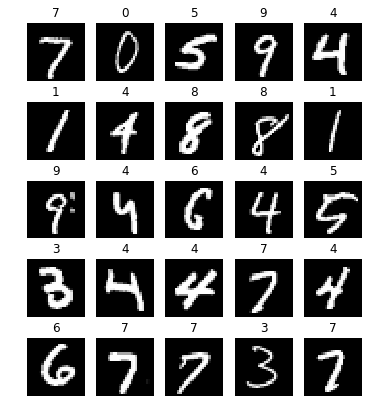

In [30]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [31]:
#activation = ReLU()
activation = Sigmoid()

inner_dim = 64

layers = [Linear(784, inner_dim), activation]
for i in range(1):
    layers.extend([Linear(inner_dim, inner_dim), activation])

layers.append(Linear(inner_dim, 10))

net = NeuralNetwork(layers)
loss = NLLLoss()

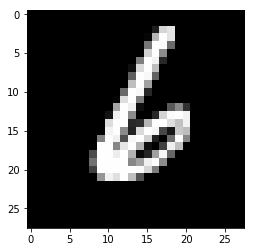

In [32]:
for X, y in train_loader:
    X = X.numpy()
    break
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)

In [33]:
x = net.forward(X[0].reshape(1, -1))[0]
order = np.argsort(x)[::-1]
print(order, x[order])

[3 4 6 7 9 2 0 1 8 5] [ 0.07120969  0.05521978  0.02837372  0.00400087  0.00324065 -0.00668696
 -0.00989457 -0.03168201 -0.04607238 -0.07497621]


In [34]:
losses = []

## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = net.forward(X)
    l = loss.forward(res, y)
    
    losses.append(l)
    
    dLdy = loss.backward()
    
    net.backward(dLdy)
    net.step(0.1)

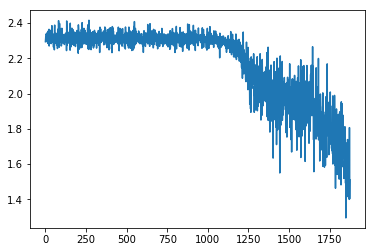

In [35]:
plt.plot(losses)
#plt.plot(sigm_losses)
#plt.plot(good_relu_losses)
plt.show()

In [36]:
good_relu_losses = losses

In [37]:
print(l)

1.5111468808513733


### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [38]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = (X > 0).astype(float)*X
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.s > 0).astype(float)*dLdy
    
    def step(self, learning_rate):
        pass

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [39]:
errors = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = net.forward(X)
    
    for x_i, y_i in zip(X, y):
        l = loss.forward(x_i.reshape(1, -1), y_i.reshape(1, -1))
        errors.append((l, x_i.reshape(28, 28)))
    
    if len(errors) > 1000:
        break

### HW1 (1 балл): Реализовать Tanh

In [40]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.Y = 2 / (1 + np.exp(-2 * X)) - 1
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        tmp = 2 / (1 + np.exp(-2 * self.X))
        self.dLdx = tmp * (2 - tmp) * dLdy
        return self.dLdx
    
    def step(self, learning_rate):
        pass

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [41]:
def set_net(activation=Sigmoid()):
    inner_dim = 64
    outter_dim = 10
    layers = [Linear(784, inner_dim), activation, Linear(inner_dim, outter_dim)]
    net = NeuralNetwork(layers)
    return net

In [42]:
loss = NLLLoss()

In [43]:
from skimage.transform import rotate  

In [44]:
def learn_net(par, rot_len=10, noize_len=3, activation=Sigmoid()):
    net = set_net(activation)
    k = 0
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        n_changes = int(y.shape[0])
        for i in range(n_changes):
            if par in ["rotation", "all"]:
                for angle in range(-rot_len, rot_len):
                    X = np.append(X, rotate_(X[i], angle)).reshape(-1, 784)
                    y = np.append(y, y[i])
            if par in ["noize", "all"]:
                for _ in range(noize_len):
                    X = np.append(X, [noise(X[i])]).reshape(-1, 784)
                    y = np.append(y, y[i])
        res = net.forward(X)
        l = loss.forward(res, y)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
    return net

In [45]:
def print_loss(par, losses, num=10):
    print("Top {0} losses on tests dataset with {1}".format(num, par))
    for i in losses[-10::]:
        print(i)
    print("\n")
    print("Mean is {}".format(np.mean(losses)))
    print("Median is {}".format(np.median(losses)))
    print("\n")

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [46]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass
    

class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

<function matplotlib.pyplot.show(*args, **kw)>

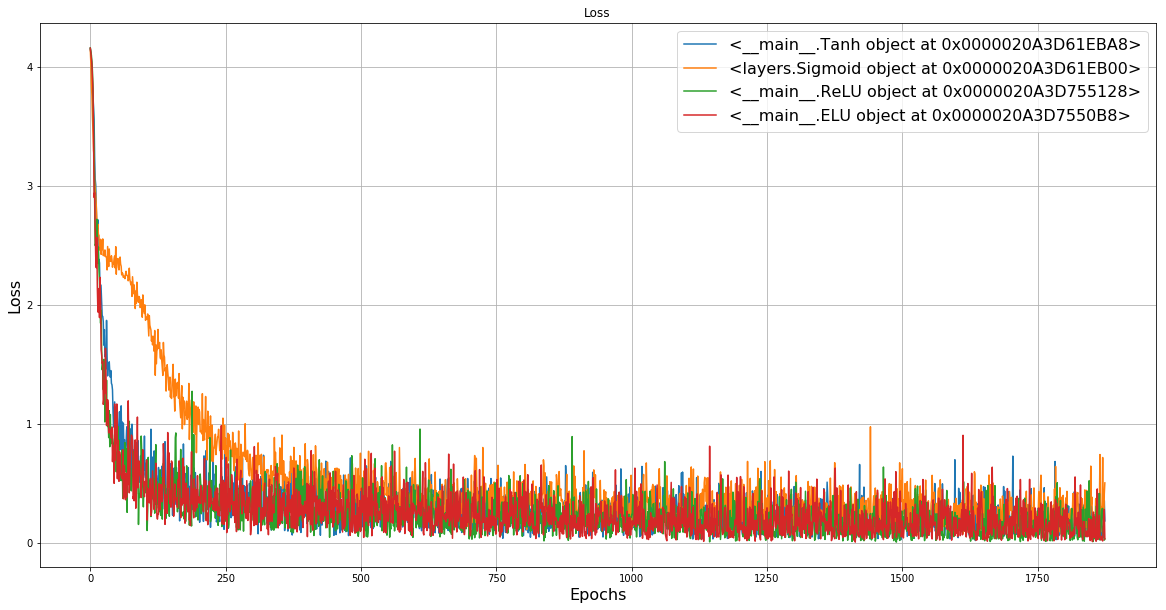

In [25]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title('Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
for activation in [Tanh(), Sigmoid(), ReLU(), ELU()]:
    losses = []
    net = set_net(activation)
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
    plt.plot(losses, label=activation)
plt.legend(loc=0, fontsize=16)
plt.show

# REDONE

In [47]:
def make_dataset(train_loader):
    data_X, data_y = np.array([]).reshape(0, 784), []
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        data_y += y.tolist()
        data_X = np.vstack((data_X, X))
    return data_X, data_y

In [48]:
def rotate_(x, angle=10):
    s = int(x.flatten().shape[0] ** 0.5)
    x = x.reshape(s, s)
    return rotate(x, angle).flatten()

def noise(x):
    s = int(x.flatten().shape[0])
    x += np.random.randn(s) * 0.2
    return x

In [49]:
def add_augm(augm, data_X, data_y):
    add_X, add_y = [], []
    if augm == "noize":
        for i in range(0, data_X.shape[0]):
            add_X += [noise(X[i]).tolist()]
            add_y += [data_y[i]]
    if augm == "rotation":
        for i in range(0, data_X.shape[0]):
            add_X += [rotate_(X[i]).tolist()]
            add_y += [data_y[i]]
    data_y += add_y
    data_X = np.vstack((data_X, np.array(add_X)))
    return data_X, data_y

In [50]:
def set_net(activation=ReLU()):
    inner_dim = 64
    outter_dim = 10
    layers = [Linear(784, inner_dim), activation, 
              Linear(inner_dim, inner_dim), activation, 
              Linear(inner_dim, inner_dim), activation,
              Linear(inner_dim, outter_dim)]
    net = NeuralNetwork(layers)
    return net
loss =NLLLoss()

In [55]:
def train_test(X_tr, y_tr, epoch=20, rot_len=2, noize_len=2, activation=ReLU()):
    fig, ax = plt.subplots()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    plt.title('Loss')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.grid()
    net = set_net(activation)
    print("Begin")
    X_test, y_test = make_dataset(test_loader)
    train_loss = []
    test_loss = []
    print("make_dataset finished correctly")
    for i in range(epoch):
        res_train = net.forward(X_tr)
        l_train = loss.forward(res_train, y_tr)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
        train_loss.append(np.mean(l_train))
        
        res_test = net.forward(X_test)
        l_test = loss.forward(res_test, y_test)
        test_loss.append(np.mean(l_test))
        print("{0} epoch finished".format(i))
    plt.plot(train_loss, label="Train")
    plt.plot(test_loss, label="Test")
    plt.legend(loc=0, fontsize=16)
    plt.show()
    print('Final loss = {0}'.format(test_loss[-1]))

In [59]:
X, y = make_dataset(train_loader)

In [60]:
import copy

In [61]:
X_tr , y_tr = add_augm("noize", copy.deepcopy(X), copy.deepcopy(y))

Begin
make_dataset finished correctly
0 epoch finished
1 epoch finished
2 epoch finished
3 epoch finished
4 epoch finished
5 epoch finished
6 epoch finished
7 epoch finished
8 epoch finished
9 epoch finished
10 epoch finished
11 epoch finished
12 epoch finished
13 epoch finished
14 epoch finished
15 epoch finished
16 epoch finished
17 epoch finished
18 epoch finished
19 epoch finished


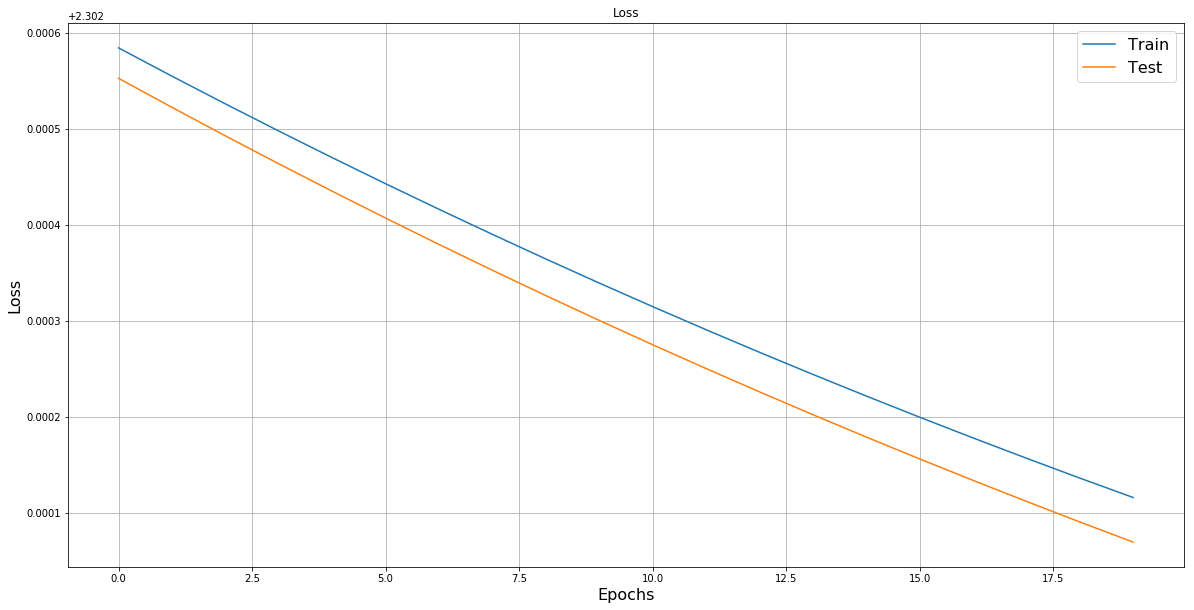

Final loss = 2.302069501316384


In [62]:
train_test(X_tr, y_tr)

In [63]:
X_tr , y_tr = add_augm("rotation", copy.deepcopy(X), copy.deepcopy(y))

Begin
make_dataset finished correctly
0 epoch finished
1 epoch finished
2 epoch finished
3 epoch finished
4 epoch finished
5 epoch finished
6 epoch finished
7 epoch finished
8 epoch finished
9 epoch finished
10 epoch finished
11 epoch finished
12 epoch finished
13 epoch finished
14 epoch finished
15 epoch finished
16 epoch finished
17 epoch finished
18 epoch finished
19 epoch finished


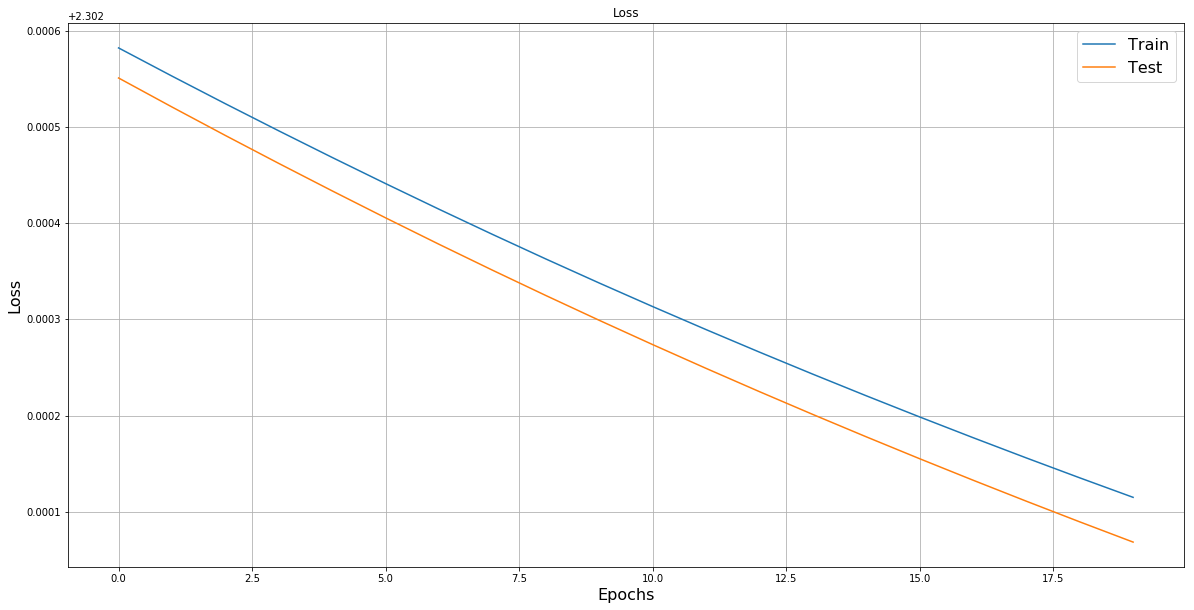

Final loss = 2.302068580913315


In [64]:
train_test(X_tr, y_tr)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Говоря о выборе нелинейности, Relu и Elu показывают одинаковый результат как на скорости сходимости, так и на Loss, Sigmoid показывает результаты хуже. Предобработка данных, получается, что не особо улучшает скорость сходимости и Loss.